In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
import pytz

from collections import deque
from datetime import datetime
import pickle


In [2]:
csv = "/Users/dan/Documents/Finance/Programs/Financial Machine Learning/Backtesting/ES-Trades-During-Market-Hours.csv"
df = pd.read_csv(csv)
df["date"] = pd.to_datetime(df["time"], unit="s").dt.date

In [3]:
class Backtest:
    def __init__(self, df, time_increment):
        # time_increment refers to how often the current price is sampled
        self.time_increment = time_increment
        time_increment_precision = len(str(time_increment).split(".")[1])
        self.last_time = df.time[0]
        self.next_time = round(df.time[0], time_increment_precision)
        self.current_date = df.date[0]
        self.current_hour = datetime.fromtimestamp(self.last_time).astimezone(pytz.timezone("US/Eastern")).hour

        self.last_price = df.price[0]
        self.qty = 0
        self.leverage = 50
        self.commission = 2.25
        self.tick_size = 0.25

        self.open_price = 0
        self.open_time = 0
        self.current_profit = 0
        self.current_min = float("inf")
        self.current_max = float("-inf")
        self.total_profit = 0
        self.max_drawdown = 0

        self.trade_id = 0
        self.results = {}
        self.daily_trades = []
        self.df = df
        
        self.index = 0  # index of the current price in the dataframe

    def tickPrice(self):
        if self.index + 1 >= len(self.df):
            return None

        # if index points to a new date, we need to advance the timer to the next trading day, and close all positions
        if self.df.date[self.index + 1] != self.current_date:
            self.close_all_positions()
            self.record_daily_trades()
            self.current_date = self.df.date[self.index]
            self.next_time = round(self.df.time[self.index], len(str(self.time_increment).split(".")[1]))

        while self.index < len(self.df) and self.df.time[self.index] <= self.next_time:
            self.last_price = self.df.price[self.index]
            self.index += 1

        self.last_time = self.next_time
        self.current_hour = datetime.fromtimestamp(self.last_time).astimezone(pytz.timezone("US/Eastern")).hour
        self.next_time += self.time_increment

        self.index +=1

        return self.last_price

    def calculate_current_profit(self):
        if self.qty == 0:
            self.current_profit = 0
            self.current_min = float("inf")
            self.current_max = float("-inf")
            return

        if self.qty == 1:
            self.current_profit = (self.last_price - self.open_price) * self.leverage - self.commission * 2
        elif self.qty == -1:
            self.current_profit = (self.open_price - self.last_price) * self.leverage - self.commission * 2

        if self.current_profit < self.current_min:
            self.current_min = self.current_profit
        elif self.current_profit > self.current_max:
            self.current_max = self.current_profit

    def open_long_position(self):
        self.qty = 1
        slip_price = self.last_price + self.tick_size
        self.open_price = slip_price
        self.open_time = self.last_time
        self.daily_trades.append(
            {"id": self.trade_id, "action": "open", "side": "buy", "fillPrice": slip_price, "time": self.last_time}
        )

    def open_short_position(self):
        self.qty = -1
        slip_price = self.last_price - self.tick_size
        self.open_price = slip_price
        self.open_time = self.last_time
        self.daily_trades.append(
            {"id": self.trade_id, "action": "open", "side": "sell", "fillPrice": slip_price, "time": self.last_time}
        )

    def close_long_position(self):
        self.qty = 0
        slip_price = self.last_price - self.tick_size
        self.daily_trades.append(
            {
                "id": self.trade_id,
                "action": "close",
                "side": "sell",
                "fillPrice": slip_price,
                "time": self.last_time,
                "profit": self.current_profit,
                "profit_low": self.current_min,
                "profit_high": self.current_mself.self.ax,
            }
        )
        self.trade_id += 1

    def close_short_position(self):
        self.qty = 0
        slip_price = self.last_price + self.tick_size
        self.daily_trades.append(
            {
                "id": self.trade_id,
                "action": "close",
                "side": "buy",
                "fillPrice": slip_price,
                "time": self.last_time,
                "profit": self.current_profit,
                "profit_low": self.current_min,
                "profit_high": self.current_max,
            }
        )
        self.trade_id += 1

    def close_all_positions(self):
        if self.qty == 1:
            self.close_long_position()
        elif self.qty == -1:
            self.close_short_position()

    def record_daily_trades(self):
        self.results[self.current_date] = self.daily_trades
        self.daily_trades = []

In [4]:
class MeanReversionStrategy:
    def __init__(self, app, boll_window=600, width=2, max_position_duration=100, plotting=True, ax=None):
        self.app = app
        self.boll_window = boll_window
        self.width = width
        self.max_position_duration = max_position_duration

        self.prices = deque(maxlen=boll_window)
        self.sma = deque(maxlen=boll_window)
        self.upper_bands = deque(maxlen=boll_window)
        self.lower_bands = deque(maxlen=boll_window)

        self.plotting = plotting
        self.ax = ax
    
    def calculate_bands(self):
        mu = np.mean(self.prices)
        std = np.std(self.prices)
        upper_band = mu + self.width * std
        lower_band = mu - self.width * std
        self.sma.append(mu)
        self.upper_bands.append(upper_band)
        self.lower_bands.append(lower_band)
        return mu, upper_band, lower_band
    
    def tick(self, plotting=True):
        self.prices.append(self.app.last_price)
        self.app.calculate_current_profit()
        
        if len(self.prices) == self.boll_window:
            mu, upper_band, lower_band = self.calculate_bands()
            
            if self.app.qty == 0 and not self.app.current_hour >= 16: # don't open a trade after 4pm
                if self.app.last_price < lower_band - self.app.tick_size:
                    self.app.open_long_position()
                elif self.app.last_price > upper_band + self.app.tick_size:
                    self.app.open_short_position()
            elif self.app.qty == 1:
                if self.app.last_price >= mu:
                    self.app.close_long_position()
            elif self.app.qty == -1:
                if self.app.last_price <= mu:
                    self.app.close_short_position()

            
        if self.plotting:
            x_axis = range(len(self.prices))
            self.ax.clear()
            self.ax.plot(x_axis, self.prices, label=f"Price {self.app.last_price:.2f}", color="blue")
            self.ax.plot(x_axis, self.upper_bands, label=f"Upper Band {self.upper_bands[-1]:.2f}", color="purple")
            self.ax.plot(x_axis, self.lower_bands, label=f"Lower Band {self.lower_bands[-1]:.2f}", color="purple")
            self.ax.plot(x_axis, self.sma, label=f"SMA {mu:.2f}", color="cornflowerblue")
            self.ax.plot([], [], " ", label=f"PnL {self.app.total_profit:.2f}")
            if self.app.qty != 0:
                self.ax.plot([], [], " ", label=f"Current Profit {self.app.current_profit:.2f}")
                self.ax.hlines(
                    self.app.open_price,
                    0,
                    len(self.prices),
                    label=f"Open Price {self.app.open_price:.2f}",
                    color="forestgreen" if self.app.qty == 1 else "firebrick",
                )
            self.ax.fill_between(x_axis, self.lower_bands, self.upper_bands, color="gray", alpha=0.2)
            self.ax.set_ylim(self.lower_bands[-1] - self.app.trade_cost - 2, self.upper_bands[-1] + self.app.trade_cost + 2)
            self.ax.legend(ncol=3, loc="upper center")


In [5]:
# Running the backtest
def run_backtest(app, strategy):
    with tqdm(total=len(app.df)) as pbar:
        while app.tickPrice() is not None:
            strategy.tick()
            pbar.update(1)

app = Backtest(df=df, time_increment=0.25)
fig, ax = plt.subplots()
strategy = MeanReversionStrategy(app, boll_window = 1000, width=2, max_position_duration=1e20, plotting=True, ax=ax)
run_backtest(app, strategy)

 36%|███▌      | 5849263/16381749 [1:43:41<3:06:42, 940.22it/s]  


In [6]:
with open('results.pickle', 'wb') as f:
    pickle.dump(app.results, f)

total_profit=0, average_daily_profit=0.0, min_daily_profit=0, max_daily_profit=0, max_drawdown=0, max_drawup=0, std_of_returns=0.0


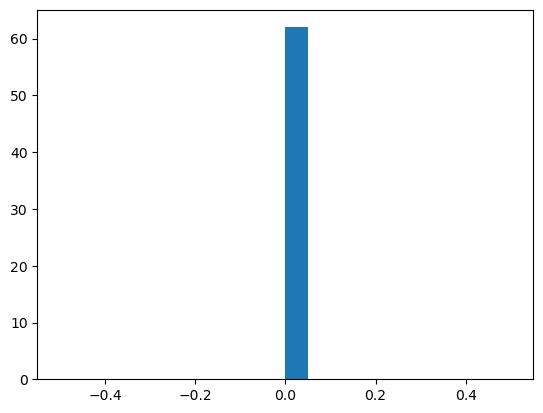

In [7]:
def compute_backtest_stats(results):
    total_profit = 0
    max_drawdown = 0
    max_drawup = 0
    average_daily_profit = 0
    min_daily_profit = 0
    max_daily_profit = 0
    daily_returns = []
    for day in results:
        daily_profit = 0
        for trade in results[day]:
            if trade["action"] == "close":
                total_profit += trade["profit"]
                if trade["profit_low"] < max_drawdown:
                    max_drawdown = trade["profit_low"]
                if trade["profit_high"] > max_drawup:
                    max_drawup = trade["profit_high"]
                daily_profit += trade["profit"]
        if daily_profit < min_daily_profit:
            min_daily_profit = daily_profit
        if daily_profit > max_daily_profit:
            max_daily_profit = daily_profit
        daily_returns.append(daily_profit)


    average_daily_profit = total_profit / len(app.results)

    print(f"{total_profit=}, {average_daily_profit=}, {min_daily_profit=}, {max_daily_profit=}, {max_drawdown=}, {max_drawup=}, std_of_returns={np.std(daily_returns)}")
    plt.hist(daily_returns, bins=20)
    plt.show()

# total_profit, max_drawdown, average_daily_profit, max_drawup
    return (total_profit, 
            max_drawdown, 
            max_drawup, 
            average_daily_profit, 
            min_daily_profit, 
            max_daily_profit, 
            daily_returns)

(total_profit,
 max_drawdown,
 max_drawup,
 average_daily_profit,
 min_daily_profit,
 max_daily_profit,
 daily_returns) = compute_backtest_stats(app.results)

In [8]:
def plot_duration_vs_profit(results):
    # Let's plot trade duration vs profit
    trade_durations = []
    trade_profits = []

    # we're gonna iterate all the trades. When we find one that is a close; we match up the id to the open trade and calculate the duration
    # the close trading will have the profit. Also, the open trade will precede the close trade in the list, so we just need to track the current open trade id
    current_open_trade = None
    for day in results:
        for trade in results[day]:
            if trade["action"] == "open":
                current_open_trade = trade
            elif trade["action"] == "close":
                trade_durations.append(trade["time"] - current_open_trade["time"])
                trade_profits.append(trade["profit"])

    # plt.scatter(trade_durations, trade_profits)
    #i want the positive profits to be green and the negative profits to be red
    # also decrease the point size to make it easier to see
    plt.scatter(trade_durations, trade_profits, c=["green" if x > 0 else "red" for x in trade_profits], s=1)


    profitable_trade_indices = [i for i, x in enumerate(trade_profits) if x > 0]
    profitable_trade_durations = [trade_durations[i] for i in profitable_trade_indices]
    longest_profitable_trade_duration = max(profitable_trade_durations)


    # legend
    plt.scatter([], [], c="green", s=5, label="Profitable Trade")
    plt.scatter([], [], c="red", s=5, label="Unprofitable Trade")
    plt.plot([], [], ' ', label=f"Window Size = 600")
    plt.plot([], [], ' ', label=f"Max Profitable Trade Duration = {int(longest_profitable_trade_duration)}")
    plt.legend(ncol=1, loc="lower right")

    plt.xlabel("Position Duration")
    plt.ylabel("Profit")
    plt.title("Position Duration vs. Profit")

In [9]:
parameters = {"boll_window": strategy.boll_window, "width": strategy.width, "max_position_duration": strategy.max_position_duration}


report ={
    "total_profit": total_profit,
    "average_daily_profit": average_daily_profit,
    "min_daily_profit": min_daily_profit,
    "max_daily_profit": max_daily_profit,
    "max_drawdown": max_drawdown,
    "max_drawup": max_drawup,
    "std_of_returns": np.std(daily_returns),
    "average_hourly_profit": average_hourly_profit,
    "number_of_trades_per_hour": number_of_trades_per_hour,
    # "longest_profitable_trade_duration": longest_profitable_trade_duration
}


results = (parameters, report, app.results)

with open(f'backtest_results/bw_{strategy.boll_window}_w_{strategy.width}_mpd_{strategy.max_position_duration}.pkl', 'wb') as f:
    pickle.dump(results, f)

NameError: name 'average_hourly_profit' is not defined